In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.utils.class_weight import compute_sample_weight

In [3]:
all_seasons = []

for season in range(2023, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
     playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600         Ryan Suter            D           82       15        0   
1     8470604        Jeff Carter            C           72        4        0   
2     8470610        Zach Parise            L           30        5        0   
3     8470613        Brent Burns            D           82       33        0   
4     8470621        Corey Perry            R           54       10        0   
..        ...                ...          ...          ...      ...      ...   
919   8484314       Jiri Smejkal            L           20        1        0   
920   8484321  Nikolas Matinpalo            D            4        0        0   
921   8484325    Waltteri Merela            C           19        0        0   
922   8484326        Patrik Koch            D            1        0        0   
923   8484911        Collin Graf            R            7        2      

In [4]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [5]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [6]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [7]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

import functools as ft
merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rush Attempts': 'rush_attempts'}, inplace=True)

In [8]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [9]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,Jeff Carter,72,4,3,3,11,90,11.45,134,95,53,9,175,18
3,Joe Pavelski,82,7,4,10,27,194,28.18,261,232,130,7,329,34
4,Alex Ovechkin,79,7,2,7,31,272,29.89,395,245,83,17,605,64
5,Evgeni Malkin,82,3,6,6,27,199,23.56,280,218,82,6,401,47
7,Sidney Crosby,82,8,6,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,Logan Cooley,82,2,2,8,20,151,16.52,217,147,57,8,284,21
556,Juraj Slafkovsky,82,2,4,5,20,152,21.56,226,198,98,5,314,27
564,Andrei Kuzmenko,72,3,5,6,22,121,19.29,197,182,97,4,265,40
566,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,401,34


In [10]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning
0,8470604,Jeff Carter,C,72,4,0,4,4
1,8470794,Joe Pavelski,C,82,40,1,4,3
2,8471214,Alex Ovechkin,L,79,34,1,5,4
3,8471215,Evgeni Malkin,C,82,40,0,2,2
4,8471675,Sidney Crosby,C,82,52,0,3,3
...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3
314,8484144,Connor Bedard,C,68,39,1,2,1


In [11]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [12]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning,GP,goals_up_by_one,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,8470604,Jeff Carter,C,72,4,0,4,4,72,4,...,3,11,90,11.45,134,95,53,9,175,18
1,8470794,Joe Pavelski,C,82,40,1,4,3,82,7,...,10,27,194,28.18,261,232,130,7,329,34
2,8471214,Alex Ovechkin,L,79,34,1,5,4,79,7,...,7,31,272,29.89,395,245,83,17,605,64
3,8471215,Evgeni Malkin,C,82,40,0,2,2,82,3,...,6,27,199,23.56,280,218,82,6,401,47
4,8471675,Sidney Crosby,C,82,52,0,3,3,82,8,...,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1,82,2,...,8,20,151,16.52,217,147,57,8,284,21
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2,82,2,...,5,20,152,21.56,226,198,98,5,314,27
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3,72,3,...,6,22,121,19.29,197,182,97,4,265,40
314,8484144,Connor Bedard,C,68,39,1,2,1,68,2,...,9,22,206,23.82,299,226,69,17,401,34


In [13]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rush_attempts, iCF, Rebounds Created]
Index: []

[0 rows x 21 columns]


In [14]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [15]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts','iCF']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [16]:
merged_clutch_goals['clutch_score'] = merged_clutch_goals['goals_when_tied_per_game'] + merged_clutch_goals['goals_down_by_one_per_game'] + merged_clutch_goals['goals_up_by_one_per_game'] + merged_clutch_goals['regulation_game_winning_per_game'] + merged_clutch_goals['ot_goals_per_game']

In [17]:
merged_clutch_goals['clutch_score'] *= 10
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False)
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(80)

,Player,clutch_score,clutch_score_rank
205,Auston Matthews,7.28,1.0
138,Sam Reinhart,6.59,2.0
166,Kyle Connor,5.85,3.0
150,David Pastrnak,5.49,4.0
96,Filip Forsberg,5.24,5.0
...,...,...,...
289,Jake Neighbours,2.73,76.0
5,Anze Kopitar,2.72,77.5
23,Gustav Nyquist,2.72,77.5
133,Anthony Mantha,2.70,79.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


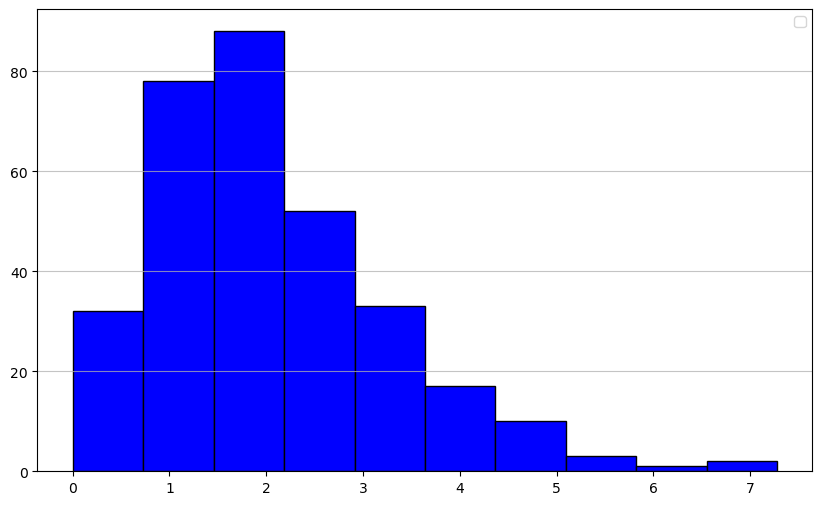

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

In [19]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [20]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    268
1     48
Name: count, dtype: int64

In [21]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [22]:
skf = StratifiedKFold(n_splits=10)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time                0.239848
score_time              0.023293
test_accuracy           0.886492
test_precision_macro    0.891379
test_recall_macro       0.787315
test_f1_macro           0.792217
dtype: float64

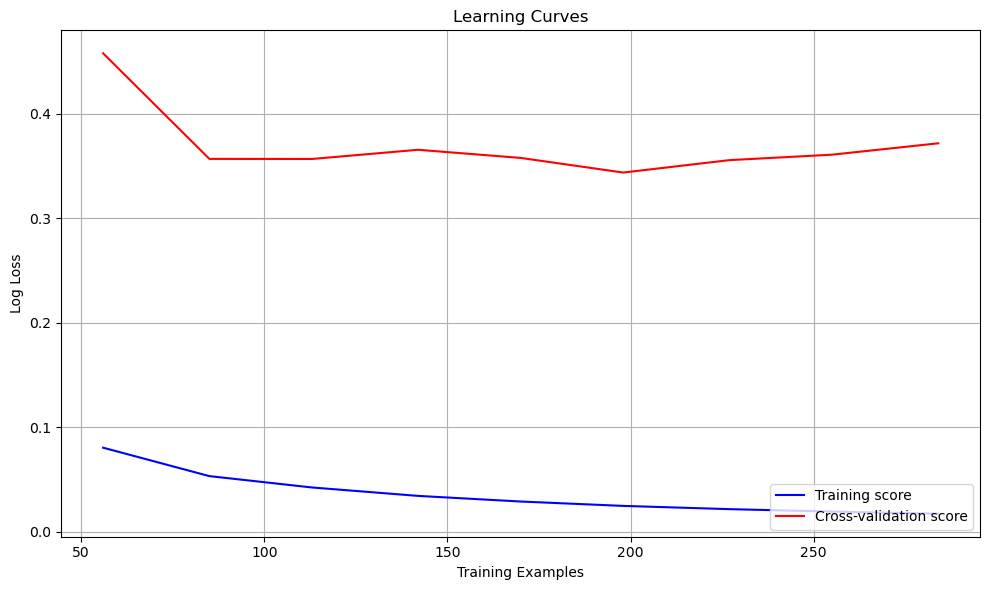

In [23]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

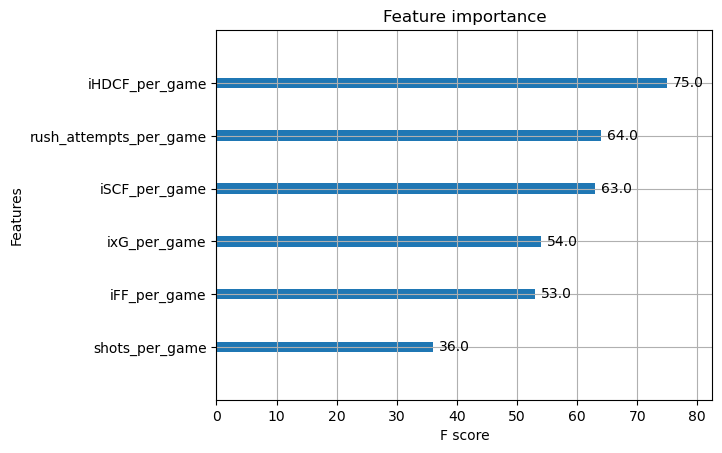

In [24]:
plot_importance(xgb_model)
plt.show()

In [25]:
merged_clutch_goals.columns

Index(['playerId', 'Player', 'positionCode', 'gamesPlayed', 'assists',
       'ot_goals', 'game_winning_goals', 'regulation_game_winning',
       'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied',
       'total_goals', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts',
       'iCF', 'Rebounds Created', 'ot_goals_per_game',
       'regulation_game_winning_per_game', 'assists_per_game',
       'goals_up_by_one_per_game', 'goals_down_by_one_per_game',
       'goals_when_tied_per_game', 'shots_per_game', 'ixG_per_game',
       'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game',
       'rush_attempts_per_game', 'iCF_per_game', 'clutch_score',
       'clutch_score_rank', 'clutch_label'],
      dtype='object')

In [26]:
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_label'
y = merged_clutch_goals[y_var]

In [27]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical

param_grid = {
    'max_depth': Integer(2,5),  # Reduced from 5 to limit complexity
    'min_child_weight': Integer(2,3),  # Increased to prevent overfitting
    'n_estimators': Integer(200, 300),  # Narrowed based on your curves
    'learning_rate': Real(0.03, 0.04),  # Slightly lower than current ~0.14
    'reg_alpha': Real(0.75, 1.9),  # Reduced from current ~1.87
    'reg_lambda': Real(0.75, 1.9),  # Reduced from current ~2.92
    'subsample': Real(0.7, 1),  # Slightly higher than current ~0.74
    'colsample_bytree': Real(0.7, 1)  # Higher than current ~0.64
}


def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}


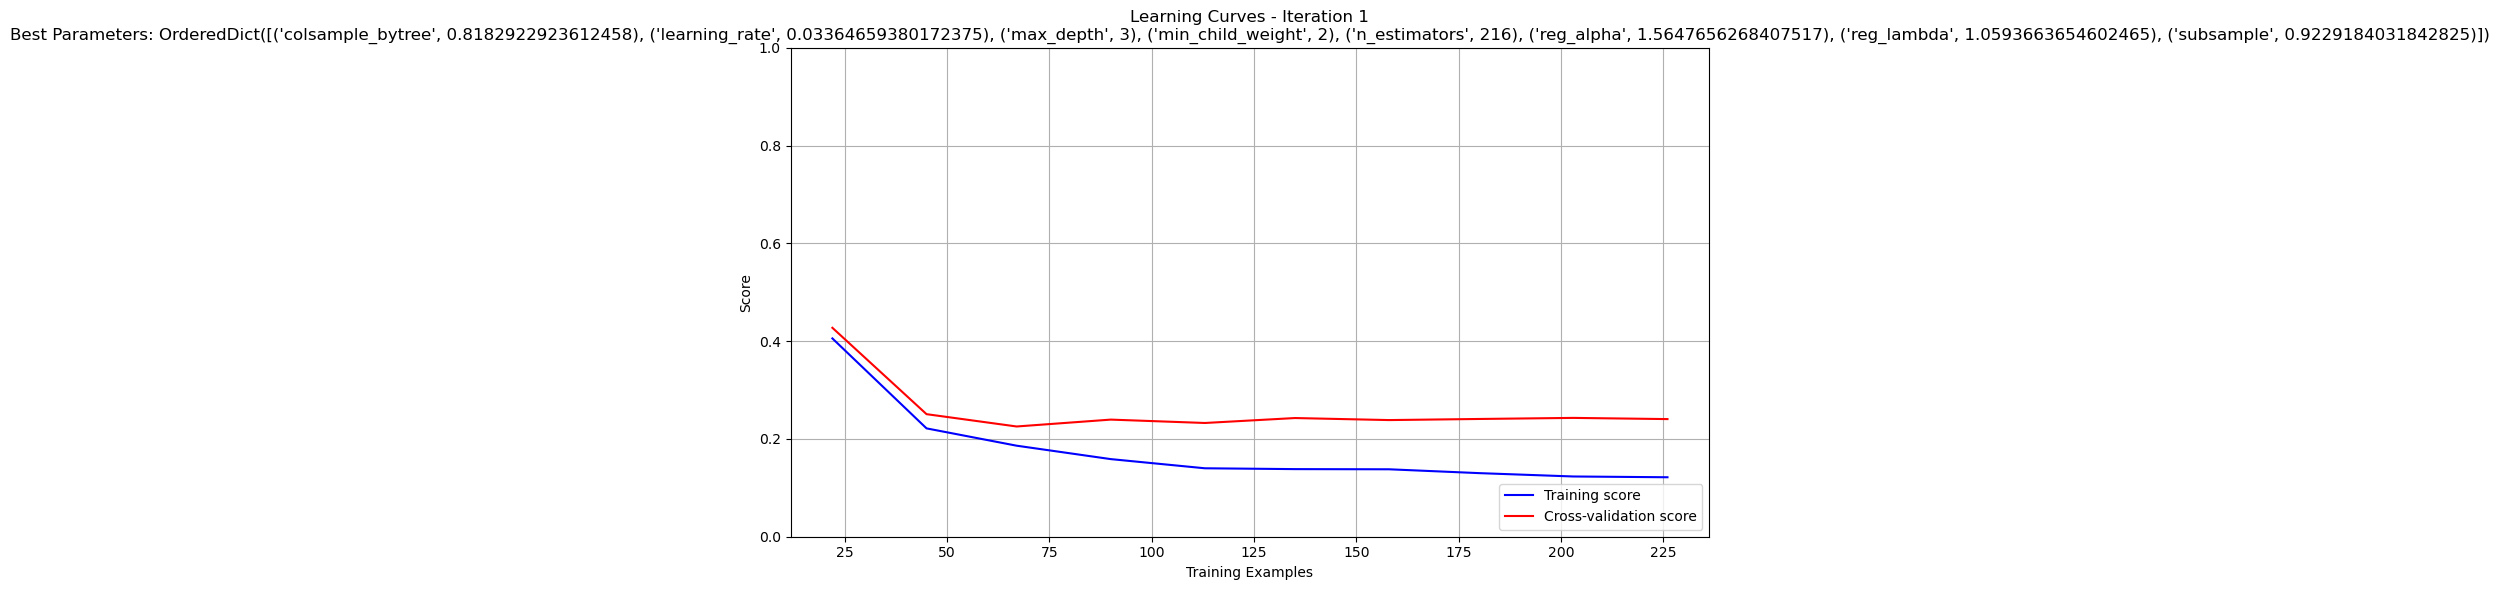

0.9375
1.0
0.6
0.7499999999999999
Average Accuracy: 0.9375
Average Precision: 1.0
Average Recall: 0.6
Average F1 Score: 0.7499999999999999
Averaged Hyperparameters:
colsample_bytree      0.818292
learning_rate         0.033647
max_depth             3.000000
min_child_weight      2.000000
n_estimators        216.000000
reg_alpha             1.564766
reg_lambda            1.059366
subsample             0.922918
dtype: float64


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(1):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1, fit_params = fit_params)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  # Probabilities for all classes

    # Metrics
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)
    print(accuracy)
    print(precision)
    print(recall)
    print(f1)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

In [32]:
# Define features and target variable
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'  # Predict the continuous clutch score directly
y = merged_clutch_goals[y_var]

# Split the data
train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Initialize XGBoost Regressor instead of Classifier
xgb_model = xgb.XGBRegressor(n_estimators=100, eval_metric='rmse')

# Fit the model
xgb_model.fit(train_x, train_y)

# Make predictions
y_pred = xgb_model.predict(test_x)

# Evaluate using regression metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


MSE: 0.7157563838129821
RMSE: 0.8460238671650949
MAE: 0.6360294981207699
R2: 0.5124090996084381


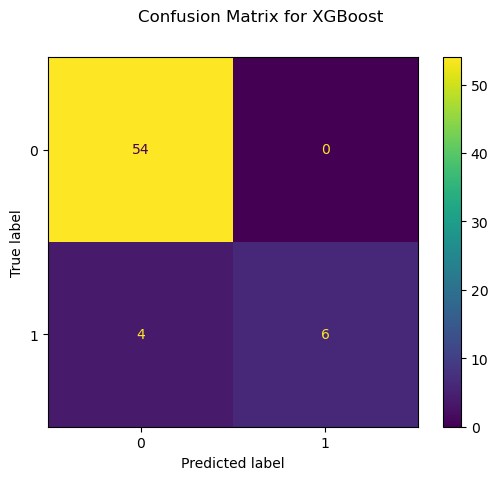

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [30]:
results = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
misclassifications = results[results['Actual'] == 1]
print(misclassifications)

     Actual  Predicted
114       1          1
20        1          1
28        1          0
254       1          1
165       1          0
4         1          1
291       1          0
124       1          1
56        1          0
273       1          1


In [31]:
y_pred_prob

array([[0.99341494, 0.00658507],
       [0.13237196, 0.86762804],
       [0.18846703, 0.811533  ],
       [0.9824726 , 0.01752738],
       [0.99333584, 0.00666416],
       [0.99341494, 0.00658507],
       [0.98084134, 0.01915869],
       [0.99341494, 0.00658507],
       [0.96802676, 0.03197321],
       [0.99335086, 0.00664913],
       [0.9866799 , 0.01332011],
       [0.9050195 , 0.09498049],
       [0.99333584, 0.00666416],
       [0.99341494, 0.00658507],
       [0.9867097 , 0.01329026],
       [0.697345  , 0.30265495],
       [0.98031414, 0.01968586],
       [0.9794056 , 0.02059444],
       [0.9298256 , 0.0701744 ],
       [0.9908356 , 0.00916441],
       [0.9892716 , 0.01072843],
       [0.98093885, 0.01906114],
       [0.99335086, 0.00664913],
       [0.99333584, 0.00666416],
       [0.99341494, 0.00658507],
       [0.98416907, 0.01583096],
       [0.76836956, 0.23163047],
       [0.99333584, 0.00666416],
       [0.99333584, 0.00666416],
       [0.23668909, 0.7633109 ],
       [0.

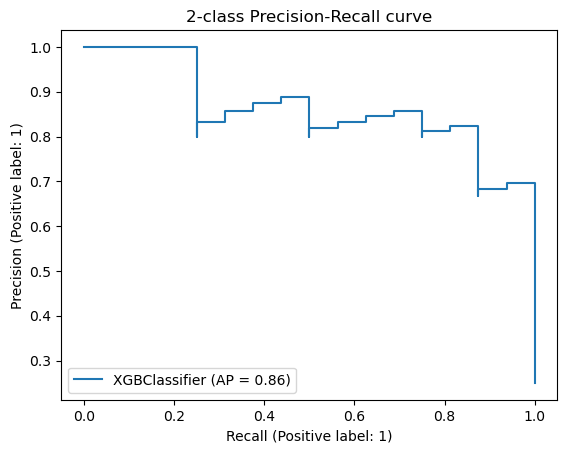

In [82]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    xgb_best_model, test_x, test_y
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


In [139]:
merged_clutch_goals.loc[82]

playerId                                8476468
Player                              J.T. Miller
positionCode                                  C
gamesPlayed                                  81
assists                                      66
ot_goals                                      2
game_winning_goals                            9
regulation_game_winning                       7
goals_up_by_one                               7
goals_down_by_one                             6
goals_when_tied                              14
total_goals                                  37
shots                                       194
ixG                                       28.27
iFF                                         304
iSCF                                        233
iHDCF                                       113
rush_attempts                                15
iCF                                         376
Rebounds Created                             32
ot_goals_per_game                      0